<a href="https://colab.research.google.com/github/ErickPol0/PortfolioProject/blob/main/Segmentaci%C3%B3n_de_clientes_%5BRFM%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentación de clientes
*Erick Polo -190300372*

#Introduccion

El objetivo de esta practica es de crear grupos de clientes, segmentandolos a partir de metricas RFM que obtenemos a partir de los datos. A fin de poder optimizar estrategias de venta. Para esta practica, de aprendizaje no supervisado, se emplea un modelo de k-medias, pero no sin antes explorar un poco los datos, limpiarlos y transformarlos. Al final se logra un perfilado de segmentos y se describen un poco.

#Exploracion y transformacion de datos

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('transactions_data.csv',delimiter = ';')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


Observamos que 25% de las observaciones en la columna de CustomerId estan vacias, esto es un problema pues, si vamos a segmentar clientes debemos conocerlos, lamentablemente la unica opcion que veo es de eliminar estos registros. 

In [ ]:
df.isna().sum() * 100 / len(df)

BillNo         0.000000
Itemname       0.278701
Quantity       0.000000
Date           0.000000
Price          0.000000
CustomerID    25.675205
Country        0.000000
dtype: float64

In [ ]:
df = df.dropna()

La columna Price dedinida como texto, no podemos anlizarla de este modo, por lo que debemos convertir el tipo de dato a float. 

In [ ]:
df['Price'] = df['Price'].str.replace(',','.')
df['Price'] = df['Price'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])

Tenemos un total de 4297 clientes diferentes para explorar

In [ ]:
len(df['CustomerID'].unique())

4297

Se abarcan transacciones realizadas entre el 12 de enero de 2010 y el 10 de diciembre de 2011.

In [ ]:
min(df['Date'])

Timestamp('2010-01-12 08:26:00')

In [ ]:
max(df['Date'])

Timestamp('2011-12-10 17:19:00')

Observamos que tenemos 388023 observacion, todo parece estar bien salvo los valores maximos de cantidad y precio, seguramente se traten de valores atipicos, por lo que debemos limpiarlos.

In [ ]:
df.describe()

,Quantity,Price,CustomerID
count,388023.000000,388023.000000,388023.000000
mean,12.892140,3.079258,15316.931710
std,182.605318,21.984569,1721.846964
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13950.000000
50%,5.000000,1.950000,15265.000000
75%,12.000000,3.750000,16837.000000
max,80995.000000,8142.750000,18287.000000


<AxesSubplot:>

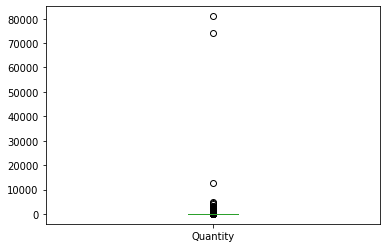

In [ ]:
df.Quantity.plot.box()

In [ ]:
df = df[df['Quantity'] < 2000]
df = df[df['Quantity'] > -4000]

<AxesSubplot:>

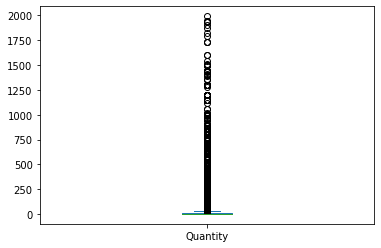

In [ ]:
df.Quantity.plot.box()

**Recencia**

¿Cuánto tiempo ha pasado entre la *fecha actual* y la de la compra más reciente del cliente? 

In [ ]:
max(df.Date)

Timestamp('2011-12-10 17:19:00')

In [ ]:
fecha_final = dt.datetime(2011,12,11) # fecha "actual"

In [ ]:
df['tiempo_trans'] = round((fecha_final - df['Date'])/pd.to_timedelta(1, unit='D'))
recencia = df.groupby("CustomerID")['tiempo_trans'].min()
recencia.head()

CustomerID
12347.0     40.0
12349.0     20.0
12350.0    311.0
12352.0     73.0
12353.0    205.0
Name: tiempo_trans, dtype: float64

**Frecuencia**

¿Cuántas compras realizó el cliente en el periodo de interés?

In [ ]:
frecuencia = df.groupby("CustomerID").size()
frecuencia.head()

CustomerID
12347.0    182
12349.0     73
12350.0     17
12352.0     85
12353.0      4
dtype: int64

**Valor monetario**

¿Cuál el ingreso obtenido por cada cliente en el periodo de interés?

In [ ]:
val_monet = df.groupby("CustomerID")['Price'].sum()
val_monet.head()

CustomerID
12347.0     481.21
12349.0     605.10
12350.0      65.30
12352.0    1354.11
12353.0      24.30
Name: Price, dtype: float64

Formamos la tabla de recencia, frecuencia, valor monetario:

In [ ]:
rfm = pd.DataFrame({'rec': recencia, "frec": frecuencia, "val_mon": val_monet})
#rfm['CostomerID'] = rfm.index
rfm.head()

,rec,frec,val_mon
CustomerID,,,
12347.0,40.0,182,481.21
12349.0,20.0,73,605.10
12350.0,311.0,17,65.30
12352.0,73.0,85,1354.11
12353.0,205.0,4,24.30


**Estandarizacion de los datos**

In [ ]:
rfms = rfm
scaler = StandardScaler()
rfms[['rec','frec','val_mon']] = scaler.fit_transform(rfms[['rec','frec','val_mon']])

In [ ]:
rfms.head()

,rec,frec,val_mon
CustomerID,,,
12347.0,-0.571940,0.431298,0.257912
12349.0,-0.745505,-0.081693,0.415345
12350.0,1.779873,-0.345249,-0.270604
12352.0,-0.285557,-0.025217,1.367146
12353.0,0.859976,-0.406431,-0.322704


#Segmentacion

Decido utilizar k-medias y para determinar el numero de grupos, empleo el metodo del codo.

In [ ]:
from sklearn.cluster import KMeans

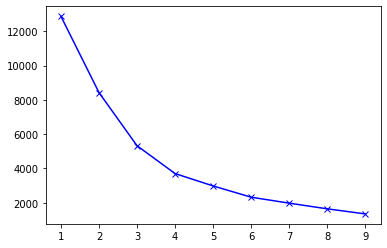

In [ ]:
var = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(rfms)
  var.append(kmeans.inertia_)

plt.plot(K,var,'bx-')
plt.show()

A partir de la grafica, determino que el punto donde la varianza empieza a bajar es 4.

In [ ]:
km = KMeans(n_clusters=4)
grupos = km.fit(rfms)

Observamos que en el grupo 1 hay solo 3 clientes, deben ser clientes muy especiales. 

In [ ]:
rfms['grupo'] = grupos.labels_
rfms.groupby('grupo').size()

grupo
0    1105
1       3
2    2967
3     219
dtype: int64

In [ ]:
rfms.head()

,rec,frec,val_mon,grupo
CustomerID,,,,
12347.0,-0.571940,0.431298,0.257912,2
12349.0,-0.745505,-0.081693,0.415345,2
12350.0,1.779873,-0.345249,-0.270604,0
12352.0,-0.285557,-0.025217,1.367146,2
12353.0,0.859976,-0.406431,-0.322704,0


**Invertir estandarizacion**

Antes de analizar los resultados e intentar describir los perfiles, es importante regresar los datos a sus escalas originales, de otro modo sería complicado hacer una interpretacíon.

In [ ]:
rfms[['rec','frec','val_mon']] = scaler.inverse_transform(rfms[['rec','frec','val_mon']])
rfms.head()

,rec,frec,val_mon,grupo
CustomerID,,,,
12347.0,40.0,182.0,481.21,2
12349.0,20.0,73.0,605.10,2
12350.0,311.0,17.0,65.30,0
12352.0,73.0,85.0,1354.11,2
12353.0,205.0,4.0,24.30,0


#Resultados

Con los datos ya de vuelta a su escala original, podemos ahora si analizar e interpretar los datos, para ello obtenemos la media de los datos para cada variable de cada grupo.

In [ ]:
df_perf = rfms.groupby(['grupo']).mean()
df_perf

,rec,frec,val_mon
grupo,,,
0,267.539367,30.288688,97.767684
1,5.666667,5851.333333,21795.513333
2,51.975396,74.248062,222.525205
3,22.356164,532.789954,1649.076438


#Grupo 0

Los clientes en el grupo 0 tienen una recencia media de 267 dias, durante los casi dos años han comprado en promedio 30 veces, y el ingreso obtenido por parte de estos clientes es de alrededor de 97 unidades. Este es el grupo menos valioso pues corresponde a clientes que no suelen visitar. 

#Grupo 1

Los clientes en el grupo 1 tienen una recencia media de 5 dias, durante los casi dos años han comprado en promedio 5851 veces, y el ingreso obtenido por parte de estos clientes es de alrededor de 21795 unidades. Este es el grupo mas valioso pues corresponde a clientes frecuentes. 

#Grupo 2

Los clientes en el grupo 2 tienen una recencia media de 52 dias, durante los casi dos años han comprado en promedio 74 veces, y el ingreso obtenido por parte de estos clientes es de alrededor de 222 unidades. No suelen pasar.

#Grupo 3

Los clientes en el grupo 3 tienen una recencia media de 22 dias, durante los casi dos años han comprado en promedio 532 veces, y el ingreso obtenido por parte de estos clientes es de alrededor de 1649 unidades. Este es el segundo grupo mas valioso pues corresponde a clientes que visitan de forma constante. 